# **Evidencia Parte 2**

Integrantes del equipo 3:

Miranda Isabel Rada Chau A01285243

Eliani González Laguna A00836712

Pablo Pérez Sandoval A01710355



In [ ]:
!pip install simpleai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.4/94.4 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for simpleai: filename=simpleai-0.8.3-py3-none-any.whl size=100985 sha256=26ad00552c74cf637a7272be8d7694071ad95c40ef36368d6e8d3f671c3330d3
  Stored in directory: /root/.cache/pip/wheels/91/0c/38/421d7910e7bc59b97fc54f490808bdb1097607d83d1a592865
Successfully built simpleai


## Preprocesamiento

In [ ]:
#------------------------------------------------------------------------------------------------------------------
#   Height map pre-processing
#------------------------------------------------------------------------------------------------------------------

#------------------------------------------------------------------------------------------------------------------
#   Imports
#------------------------------------------------------------------------------------------------------------------
import copy
import numpy as np
from skimage.transform import downscale_local_mean
import matplotlib as plt
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import plotly.graph_objects as px

#------------------------------------------------------------------------------------------------------------------
#   File names
#------------------------------------------------------------------------------------------------------------------
input_file = "/content/mars_map.IMG"
output_file = "mars_map.npy"


#------------------------------------------------------------------------------------------------------------------
#   Load map data
#------------------------------------------------------------------------------------------------------------------

data_file = open(input_file, "rb")

endHeader = False;
while not endHeader:
    line = data_file.readline().rstrip().lower()

    sep_line = line.split(b'=')

    if len(sep_line) == 2:
        itemName = sep_line[0].rstrip().lstrip()
        itemValue = sep_line[1].rstrip().lstrip()

        if itemName == b'valid_maximum':
            maxV = float(itemValue)
        elif itemName == b'valid_minimum':
            minV = float(itemValue)
        elif itemName == b'lines':
            n_rows = int(itemValue)
        elif itemName == b'line_samples':
            n_columns = int(itemValue)
        elif itemName == b'map_scale':
            scale_str = itemValue.split()
            if len(scale_str) > 1:
                scale = float(scale_str[0])

    elif line == b'end':
        endHeader = True
        char = 0
        while char == 0 or char == 32:
            char = data_file.read(1)[0]
        pos = data_file.seek(-1, 1)

image_size = n_rows*n_columns
data = data_file.read(4*image_size)

image_data = np.frombuffer(data, dtype=np.dtype('f'))
image_data = image_data.reshape((n_rows, n_columns))
image_data = np.array(image_data)
image_data = image_data.astype('float64')

image_data = image_data - minV;
image_data[image_data < -10000] = -1;

#------------------------------------------------------------------------------------------------------------------
#   Subsampling
#------------------------------------------------------------------------------------------------------------------
sub_rate = round(10/scale)

image_data = downscale_local_mean(image_data, (sub_rate, sub_rate))
image_data[image_data<0] = -1

print('Sub-sampling:', sub_rate)

new_scale = scale*sub_rate
print('New scale:', new_scale, 'meters/pixel')



## Mapa

In [ ]:
#------------------------------------------------------------------------------------------------------------------
#   Save map
#------------------------------------------------------------------------------------------------------------------
np.save(output_file, image_data)

#------------------------------------------------------------------------------------------------------------------
#   Show 3D surface
#------------------------------------------------------------------------------------------------------------------

x = new_scale*np.arange(image_data.shape[1])
y = new_scale*np.arange(image_data.shape[0])
X, Y = np.meshgrid(x, y)

fig = px.Figure(data = px.Surface(x=X, y=Y, z=np.flipud(image_data), colorscale='hot', cmin = 0,
                           lighting = dict(ambient = 0.0, diffuse = 0.8, fresnel = 0.02, roughness = 0.4, specular = 0.2),
                           lightposition=dict(x=0, y=n_rows/2, z=2*maxV)),

                layout = px.Layout(scene_aspectmode='manual',
                                   scene_aspectratio=dict(x=1, y=n_rows/n_columns, z=max((maxV-minV)/x.max(), 0.2)),
                                   scene_zaxis_range = [0,maxV-minV])
                )

fig.show()


## Muestra de la superficie

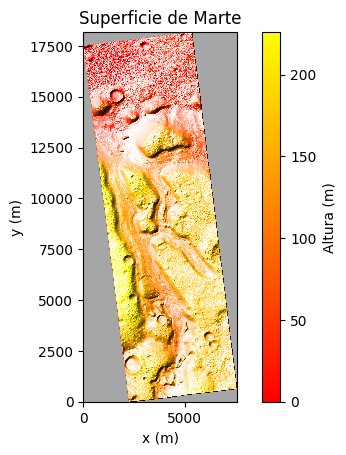

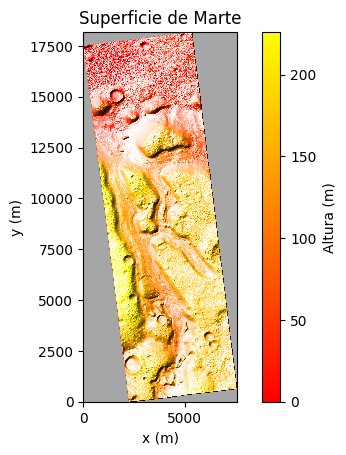

In [ ]:
#------------------------------------------------------------------------------------------------------------------
#   Show surface image
#------------------------------------------------------------------------------------------------------------------

cmap = copy.copy(plt.colormaps.get_cmap('autumn'))
cmap.set_under(color='black')

ls = LightSource(315, 45)
rgb = ls.shade(image_data, cmap=cmap, vmin = 0, vmax = image_data.max(), vert_exag=2, blend_mode='hsv')

fig, ax = plt.subplots()

im = ax.imshow(rgb, cmap=cmap, vmin = 0, vmax = image_data.max(),
                extent =[0, scale*n_columns, 0, scale*n_rows],
                interpolation ='nearest', origin ='upper')

cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Altura (m)')

plt.title('Superficie de Marte')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()
#------------------------------------------------------------------------------------------------------------------
#   Show surface image
#------------------------------------------------------------------------------------------------------------------

cmap = copy.copy(plt.colormaps.get_cmap('autumn'))
cmap.set_under(color='black')

ls = LightSource(315, 45)
rgb = ls.shade(image_data, cmap=cmap, vmin = 0, vmax = image_data.max(), vert_exag=2, blend_mode='hsv')

fig, ax = plt.subplots()

im = ax.imshow(rgb, cmap=cmap, vmin = 0, vmax = image_data.max(),
                extent =[0, scale*n_columns, 0, scale*n_rows],
                interpolation ='nearest', origin ='upper')

cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Altura (m)')

plt.title('Superficie de Marte')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()


## Carga de archivo y calculo de renglones y columnas

In [ ]:
#------------------------------------------------------------------------------------------------------------------
#   Cargar el archivo
#------------------------------------------------------------------------------------------------------------------

mars_map = np.load('mars_map.npy')
nr, nc = mars_map.shape
escala = new_scale
#------------------------------------------------------------------------------------------------------------------
#   Calcular el renglon r y columna c de una coordenada x y y
#-------------------------------------------------------

#Cambiar las coordenadas X Y a coordenadas en el mapa con renglones y columnas
def coordenadas_escala(x,y,escala,nr):
   r=nr-round(y/escala)
   c=round(x/escala)
   return  (r,c)

def descoordenas(r,c,escala, nr):
  x=c*escala
  y=(nr-r)*escala
  return(x,y)
#cambiar renglones y columnas a coordenadas en x y

## PSA

In [ ]:
#-------------------------------------------------------------------------------
#    Esqueleto de PSA para el problema de Rover en Marte
#-------------------------------------------------------------------------------

from simpleai.search import SearchProblem, depth_first, breadth_first, uniform_cost, greedy, astar,iterative_limited_depth_first
from simpleai.search.viewers import BaseViewer, ConsoleViewer, WebViewer

#-------------------------------------------------------------------------------
#   Definición del problema
#-------------------------------------------------------------------------------

class Rover(SearchProblem):
    """
        Clase que es usada para crear el objeto problema. Los estados son representados con
        una estructura en Python que guarde la información descrita en la formulación del PSA.
    """

    def __init__(self, x_inic,y_inic,x_fin,y_fin,diferencia):
        """ Constructor de la clase. Inicializa el problema de acuerdo un conjunto de
            argumentos.

            Punto inicial: una tupla con las coordenadas iniciales
            Punto final: una tupla con las coordenadas finales
            Diferencia: Diferencia entre la altura inicial y la altura final admisible

        """
        self.x_inicial = x_inic
        self.y_inicial = y_inic

        self.x_final = x_fin
        self.y_final = y_fin
        self.punto_final = (self.x_final,self.y_final)
        #self.renglon = 1814-round(self.y/escala)
        #self.columna = round(self.x/escala)
        self.diferencia = diferencia


        self.movimientos = {1 : [0,1], 2: [1,1], 3:[1,0], 4:[1,-1], 5:[0,-1],
                       6: [-1,-1], 7:[-1,0], 8:[-1,1] }

#El orden de los movimientos va definido en el orden de las manecillas del reloj, siendo el primero a las 12


        # Construye el estado inicial a partir de los argumentos especificados de acuerdo
        # a lo definido en la formulación del PSA.
        #self.punto_inicial = coordenadas_escala(self.x_inicial,self.y_inicial)
        # Llama al constructor de su superclase SearchProblem (start = estado inicial).
        SearchProblem.__init__(self, punto_inicial)

        # Define el estado meta (opcional).
        self.goal_state = punto_final




    def actions(self, state):

      vecinos = []
      for movimiento in self.movimientos:
          nuevo_renglon = state[0] + self.movimientos[movimiento][0]
          nueva_columna = state[1] + self.movimientos[movimiento][1]
          altura_actual = mars_map[state[0]][state[1]]
          nueva_altura = mars_map[nuevo_renglon][nueva_columna]
          if abs(altura_actual - nueva_altura) < diferencia and nueva_altura != -1:
              vecinos.append(movimiento)

      # for movimiento in self.movimientos:
      #   nuevo_renglon = state[0] + self.movimientos[movimiento][0]
      #   nueva_columna = state[1] + self.movimientos[movimiento][1]

      #   altura_actual = mars_map[state[0],state[1]]
      #   nueva_altura = mars_map[nuevo_renglon,nueva_columna]
      #   #Comprobar si es posible el movimiento
      #   if abs(altura_actual - nueva_altura < diferencia) and nueva_altura != -1:
      #     vecinos.append(movimiento)

      """
            Regresa una lista con las acciones legales del agente.

            state: punto_actual
            Las únicas acciones que puede realizar el rover es moverse en dirección
            a sus pixeles adyacentes.
      """


        # Determina las acciones legales según el estado recibido y las precondiciones
        # de cada acción posible, para luego colocarlas en una lista de python

      return vecinos

    def result(self, state, action):
      nuevo_renglon = state[0] + self.movimientos[action][0]
      nueva_columna = state[1] + self.movimientos[action][1]

      avanza = (nuevo_renglon, nueva_columna)
      return avanza



    def is_goal(self, state):
        """
            Determina si se ha llegado a un estado meta.

            state: Estado a ser evaluado.
        """
        if state == self.goal_state:
          return True
        else:
          return False

    def cost(self, state, action, state2):
        # regresa un número que representa el costo de ejecutar action sobre
        # el estado state para producir el estado state2
        costo = np.linalg.norm(np.asarray(state) - np.asarray(state2))
        return costo

    def heuristic(self, state):
        """
            Regresa valor de la heurística para algoritmos de búsqueda con información.

            state: ...
        """

        # Estima y regresa la distancia desde el estado dado a su meta más cercana.
        dist = np.linalg.norm(np.asarray(state) - np.asarray(self.goal_state))
        return dist

# Despliega la secuencia de estados y acciones obtenidas como resultado
# def display(result):
#     if result is not None:
#         for i, (action, state) in enumerate(result.path()):
#             if action == None:
#                 print('Estado inicial')
#             elif i == len(result.path()) - 1:
#                 print(i,'- Después de la accion', action)
#                 print('¡Meta lograda con costo =', result.cost,'!')
#             else:
#                 print(i,'- Después de la accion', action)

#             print('  ', state)
#     else:
#         print('Falla: No se pudo resolver el problema')

def display(result):
    distancias = []
    distancia0 = 0
    suma = 0
    print(result)
    if result is not None:
        for i, (action, state) in enumerate(result.path()):
            distancia1= mars_map[state[0],state[1]]
            distancias.append(abs(distancia1-distancia0))
            distancia0=distancia1
            if action == None:
                print('Estado inicial')
            elif i == len(result.path()) - 1:
                print(i,'- Después de la accion', action)
                print('¡Meta lograda con costo =', result.cost,'!')
                for m in range(1, len(distancias)):
                  suma+=distancias[m]
                print("Se recorrio una distancia de", suma )
            else:
                print(i,'- Después de la accion', action)

            print('  ', state)
    else:
        print('Falla: No se pudo resolver el problema')


## Algoritmos de búsqueda

In [ ]:
#-------------------------------------------------------------------------------
#   Solución de la busqueda por primero en anchura
#-------------------------------------------------------------------------------

# Posibles expectadores para las búsquedas
my_viewer = None

def ejecutar_busqueda_anchura(x_inic, y_inic, x_fin, y_fin, diferencia):
    # Crea una instancia de Rover con tus variables
    rover = Rover(x_inic, y_inic, x_fin, y_fin, diferencia)

    #Primero en anchura
    result = breadth_first(rover, graph_search=False, viewer=my_viewer)
    print()
    print('>> Búsqueda Primero en Anchura <<')
    display(result)
    return result

# despliega las estadísticas de búsqueda si no se seleccionó un espectador
if my_viewer != None:
    print('Estadisticas:')
    print(my_viewer.stats)



In [ ]:
x_inicial = 2850
y_inicial = 6400
x_final = 3150
y_final = 6800
diferencia = 0.25
punto_inicial = coordenadas_escala(x_inicial,y_inicial, escala, nr)
punto_final = coordenadas_escala(x_final,y_final, escala, nr)



In [ ]:
ejecutar_busqueda_anchura(punto_inicial[0],punto_inicial[1],punto_final[0],punto_final[1],diferencia)

KeyboardInterrupt: 

In [ ]:
#-------------------------------------------------------------------------------
#   Solución de la busqueda por primero en profundidad
#-------------------------------------------------------------------------------

# Posibles expectadores para las búsquedas
my_viewer = None

def ejecutar_busqueda_profundidad(x_inic, y_inic, x_fin, y_fin, diferencia):
    # Crea una instancia de Rover con tus variables
    rover = Rover(x_inic, y_inic, x_fin, y_fin, diferencia)

    #Primero en anchura
    result = depth_first(rover, graph_search=True, viewer=my_viewer)
    print()
    print('>> Búsqueda Primero en Profundidad <<')
    display(result)
    return result

# despliega las estadísticas de búsqueda si no se seleccionó un espectador
if my_viewer != None:
    print('Estadisticas:')
    print(my_viewer.stats)

In [ ]:
ejecutar_busqueda_profundidad(punto_inicial[0],punto_inicial[1],punto_final[0],punto_final[1],diferencia)

Se han truncado las últimas 5000 líneas del flujo de salida.
494 - Después de la accion 7
   (980, 265)
495 - Después de la accion 7
   (979, 265)
496 - Después de la accion 7
   (978, 265)
497 - Después de la accion 7
   (977, 265)
498 - Después de la accion 8
   (976, 266)
499 - Después de la accion 8
   (975, 267)
500 - Después de la accion 8
   (974, 268)
501 - Después de la accion 8
   (973, 269)
502 - Después de la accion 8
   (972, 270)
503 - Después de la accion 7
   (971, 270)
504 - Después de la accion 8
   (970, 271)
505 - Después de la accion 8
   (969, 272)
506 - Después de la accion 7
   (968, 272)
507 - Después de la accion 6
   (967, 271)
508 - Después de la accion 7
   (966, 271)
509 - Después de la accion 7
   (965, 271)
510 - Después de la accion 6
   (964, 270)
511 - Después de la accion 7
   (963, 270)
512 - Después de la accion 6
   (962, 269)
513 - Después de la accion 5
   (962, 268)
514 - Después de la accion 7
   (961, 268)
515 - Después de la accion 1
   (961

Node <(1136, 314)>

In [ ]:
#-------------------------------------------------------------------------------
#   Solución de la busqueda greedy
#-------------------------------------------------------------------------------

# Posibles expectadores para las búsquedas
my_viewer = None

def ejecutar_busqueda_greedy(x_inic, y_inic, x_fin, y_fin, diferencia):
    # Crea una instancia de Rover con tus variables
    rover = Rover(x_inic, y_inic, x_fin, y_fin, diferencia)

    #Busqueda greedy
    result = greedy(rover, graph_search=True, viewer=my_viewer)
    print()
    print('>> Búsqueda greedy <<')
    display(result)
    return result

# despliega las estadísticas de búsqueda si no se seleccionó un espectador
if my_viewer != None:
    print('Estadisticas:')
    print(my_viewer.stats)

In [ ]:
ejecutar_busqueda_greedy(punto_inicial[0],punto_inicial[1],punto_final[0],punto_final[1],diferencia)


>> Búsqueda greedy <<
Node <(1136, 314)>
Estado inicial
   (1176, 285)
1 - Después de la accion 8
   (1175, 286)
2 - Después de la accion 8
   (1174, 287)
3 - Después de la accion 7
   (1173, 287)
4 - Después de la accion 6
   (1172, 286)
5 - Después de la accion 7
   (1171, 286)
6 - Después de la accion 1
   (1171, 287)
7 - Después de la accion 7
   (1170, 287)
8 - Después de la accion 7
   (1169, 287)
9 - Después de la accion 6
   (1168, 286)
10 - Después de la accion 6
   (1167, 285)
11 - Después de la accion 6
   (1166, 284)
12 - Después de la accion 6
   (1165, 283)
13 - Después de la accion 7
   (1164, 283)
14 - Después de la accion 7
   (1163, 283)
15 - Después de la accion 7
   (1162, 283)
16 - Después de la accion 8
   (1161, 284)
17 - Después de la accion 8
   (1160, 285)
18 - Después de la accion 7
   (1159, 285)
19 - Después de la accion 7
   (1158, 285)
20 - Después de la accion 1
   (1158, 286)
21 - Después de la accion 8
   (1157, 287)
22 - Después de la accion 1
   (11

Node <(1136, 314)>

In [ ]:
#-------------------------------------------------------------------------------
#   Solución de la busqueda por A*
#-------------------------------------------------------------------------------

# Posibles expectadores para las búsquedas
my_viewer = None

def ejecutar_busqueda_a(x_inic, y_inic, x_fin, y_fin, diferencia):
    # Crea una instancia de Rover con tus variables
    rover = Rover(x_inic, y_inic, x_fin, y_fin, diferencia)

    #Búsqueda A*
    #Ojo: requiere tener definida la heurística
    result = astar(rover, graph_search=True, viewer=my_viewer)
    print()
    print('>> Búsqueda A* <<')
    display(result)
    return result

# despliega las estadísticas de búsqueda si no se seleccionó un espectador
if my_viewer != None:
    print('Estadisticas:')
    print(my_viewer.stats)

In [ ]:
ejecutar_busqueda_a(punto_inicial[0],punto_inicial[1],punto_final[0],punto_final[1],diferencia)


>> Búsqueda A* <<
Node <(1136, 314)>
Estado inicial
   (1176, 285)
1 - Después de la accion 7
   (1175, 285)
2 - Después de la accion 7
   (1174, 285)
3 - Después de la accion 7
   (1173, 285)
4 - Después de la accion 7
   (1172, 285)
5 - Después de la accion 7
   (1171, 285)
6 - Después de la accion 6
   (1170, 284)
7 - Después de la accion 7
   (1169, 284)
8 - Después de la accion 7
   (1168, 284)
9 - Después de la accion 7
   (1167, 284)
10 - Después de la accion 7
   (1166, 284)
11 - Después de la accion 6
   (1165, 283)
12 - Después de la accion 7
   (1164, 283)
13 - Después de la accion 7
   (1163, 283)
14 - Después de la accion 7
   (1162, 283)
15 - Después de la accion 8
   (1161, 284)
16 - Después de la accion 7
   (1160, 284)
17 - Después de la accion 7
   (1159, 284)
18 - Después de la accion 7
   (1158, 284)
19 - Después de la accion 7
   (1157, 284)
20 - Después de la accion 7
   (1156, 284)
21 - Después de la accion 7
   (1155, 284)
22 - Después de la accion 6
   (1154, 

Node <(1136, 314)>

# Preguntas de Análisis

**¿Qué algoritmos lograron encontrar una ruta válida?**

Los únicos algoritmos que encontraron una ruta válida fueron el algoritmo primero en profundidad, el algoritmo greedy y el algoritmo A*. Con esto se pudo observar que 2 de los métodos que funcionaron de la manera apropiada fueron los algoritmos de búsqueda informados que utilizan la heurística para encontrar la mejor ruta posible.

**¿Es necesario utilizar búsquedas informadas para este caso?**

Si es necesario usar búsquedas informadas, ya que estas son 2 de las únicas que sí dan una respuesta en tiempos aceptables. Hicimos varias pruebas con diferentes tipos de coordenadas con búsquedas no informadas, pero o resultaban sin solución o se tardaban mucho tiempo en darla, a veces no terminaban de correr y la sesión de collab se reiniciaba debido a que se terminaba la cantidad de RAM disponible. Estos problemas que tuvimos con las búsquedas no informadas, hacen que las búsquedas informadas sean fundamentales para la realización adecuada de este proyecto.

**¿Qué función heurística resultó adecuada para este problema?**

En este caso consideramos que la heurística apropiada es la distancia euclideana entre un estado y el estado al que se dirige. Consideramos que está heurística es apropiada, ya que la manera en que se mueve el agente a través de los pixeles se decide a través de las distancias que recorre, por lo tanto, la distancia euclideana de un punto a otro sería un buen punto de comparación para estas medidas.

# Coordenadas con menos de 500 metros de diferencia.

In [ ]:
x_inicial = 3210
y_inicial = 7510
x_final = 3260
y_final = 7550
diferencia = 0.25
punto_inicial = coordenadas_escala(x_inicial,y_inicial, escala, nr)
punto_final = coordenadas_escala(x_final,y_final, escala, nr)
ejecutar_busqueda_a(punto_inicial[0],punto_inicial[1],punto_final[0],punto_final[1],diferencia)


>> Búsqueda A* <<
Node <(1061, 325)>
Estado inicial
   (1065, 320)
1 - Después de la accion 1
   (1065, 321)
2 - Después de la accion 8
   (1064, 322)
3 - Después de la accion 1
   (1064, 323)
4 - Después de la accion 8
   (1063, 324)
5 - Después de la accion 7
   (1062, 324)
6 - Después de la accion 8
¡Meta lograda con costo = 7.242640687119285 !
Se recorrio una distancia de 1.0307055664062545
   (1061, 325)


Node <(1061, 325)>

In [ ]:
x_inicial = 3150
y_inicial = 7370
x_final = 3250
y_final = 7480
diferencia = 0.25
punto_inicial = coordenadas_escala(x_inicial,y_inicial, escala, nr)
punto_final = coordenadas_escala(x_final,y_final, escala, nr)
ejecutar_busqueda_a(punto_inicial[0],punto_inicial[1],punto_final[0],punto_final[1],diferencia)


>> Búsqueda A* <<
Node <(1068, 324)>
Estado inicial
   (1079, 314)
1 - Después de la accion 1
   (1079, 315)
2 - Después de la accion 1
   (1079, 316)
3 - Después de la accion 7
   (1078, 316)
4 - Después de la accion 7
   (1077, 316)
5 - Después de la accion 7
   (1076, 316)
6 - Después de la accion 7
   (1075, 316)
7 - Después de la accion 1
   (1075, 317)
8 - Después de la accion 7
   (1074, 317)
9 - Después de la accion 1
   (1074, 318)
10 - Después de la accion 7
   (1073, 318)
11 - Después de la accion 7
   (1072, 318)
12 - Después de la accion 7
   (1071, 318)
13 - Después de la accion 8
   (1070, 319)
14 - Después de la accion 1
   (1070, 320)
15 - Después de la accion 8
   (1069, 321)
16 - Después de la accion 1
   (1069, 322)
17 - Después de la accion 1
   (1069, 323)
18 - Después de la accion 8
¡Meta lograda con costo = 19.242640687119287 !
Se recorrio una distancia de 3.026530761718746
   (1068, 324)


Node <(1068, 324)>

# Coordenadas a más de 1000 pero menos de 5000 metros

In [ ]:
x_inicial = 2890
y_inicial = 16000
x_final = 3650
y_final = 16500
diferencia = 0.25
punto_inicial = coordenadas_escala(x_inicial,y_inicial, escala, nr)
punto_final = coordenadas_escala(x_final,y_final, escala, nr)
ejecutar_busqueda_a(punto_inicial[0],punto_inicial[1],punto_final[0],punto_final[1],diferencia)


>> Búsqueda A* <<
Node <(168, 364)>
Estado inicial
   (218, 289)
1 - Después de la accion 7
   (217, 289)
2 - Después de la accion 8
   (216, 290)
3 - Después de la accion 7
   (215, 290)
4 - Después de la accion 8
   (214, 291)
5 - Después de la accion 1
   (214, 292)
6 - Después de la accion 1
   (214, 293)
7 - Después de la accion 2
   (215, 294)
8 - Después de la accion 1
   (215, 295)
9 - Después de la accion 6
   (214, 294)
10 - Después de la accion 8
   (213, 295)
11 - Después de la accion 7
   (212, 295)
12 - Después de la accion 7
   (211, 295)
13 - Después de la accion 7
   (210, 295)
14 - Después de la accion 7
   (209, 295)
15 - Después de la accion 7
   (208, 295)
16 - Después de la accion 8
   (207, 296)
17 - Después de la accion 7
   (206, 296)
18 - Después de la accion 8
   (205, 297)
19 - Después de la accion 8
   (204, 298)
20 - Después de la accion 1
   (204, 299)
21 - Después de la accion 8
   (203, 300)
22 - Después de la accion 1
   (203, 301)
23 - Después de la 

Node <(168, 364)>

In [ ]:
x_inicial = 3550
y_inicial = 16300
x_final = 4650
y_final = 16500
diferencia = 0.25
punto_inicial = coordenadas_escala(x_inicial,y_inicial, escala, nr)
punto_final = coordenadas_escala(x_final,y_final, escala, nr)
ejecutar_busqueda_a(punto_inicial[0],punto_inicial[1],punto_final[0],punto_final[1],diferencia)


>> Búsqueda A* <<
Node <(168, 464)>
Estado inicial
   (188, 354)
1 - Después de la accion 5
   (188, 353)
2 - Después de la accion 5
   (188, 352)
3 - Después de la accion 6
   (187, 351)
4 - Después de la accion 7
   (186, 351)
5 - Después de la accion 6
   (185, 350)
6 - Después de la accion 6
   (184, 349)
7 - Después de la accion 7
   (183, 349)
8 - Después de la accion 8
   (182, 350)
9 - Después de la accion 7
   (181, 350)
10 - Después de la accion 7
   (180, 350)
11 - Después de la accion 7
   (179, 350)
12 - Después de la accion 6
   (178, 349)
13 - Después de la accion 6
   (177, 348)
14 - Después de la accion 6
   (176, 347)
15 - Después de la accion 7
   (175, 347)
16 - Después de la accion 6
   (174, 346)
17 - Después de la accion 6
   (173, 345)
18 - Después de la accion 5
   (173, 344)
19 - Después de la accion 5
   (173, 343)
20 - Después de la accion 7
   (172, 343)
21 - Después de la accion 7
   (171, 343)
22 - Después de la accion 8
   (170, 344)
23 - Después de la 

Node <(168, 464)>

# Pruebas con coordenadas a más de 10,000 metros de distancia.

In [ ]:
x_inicial = 3750
y_inicial = 5800
x_final = 4850
y_final = 16500
diferencia = 0.25
punto_inicial = coordenadas_escala(x_inicial,y_inicial, escala, nr)
punto_final = coordenadas_escala(x_final,y_final, escala, nr)
ejecutar_busqueda_a(punto_inicial[0],punto_inicial[1],punto_final[0],punto_final[1],diferencia)


>> Búsqueda A* <<
None
Falla: No se pudo resolver el problema


In [ ]:
x_inicial = 3500
y_inicial = 4500
x_final = 4650
y_final = 15500
diferencia = 0.25
punto_inicial = coordenadas_escala(x_inicial,y_inicial, escala, nr)
punto_final = coordenadas_escala(x_final,y_final, escala, nr)
ejecutar_busqueda_a(punto_inicial[0],punto_inicial[1],punto_final[0],punto_final[1],diferencia)


>> Búsqueda A* <<
Node <(268, 464)>
Estado inicial
   (1366, 349)
1 - Después de la accion 7
   (1365, 349)
2 - Después de la accion 8
   (1364, 350)
3 - Después de la accion 7
   (1363, 350)
4 - Después de la accion 7
   (1362, 350)
5 - Después de la accion 7
   (1361, 350)
6 - Después de la accion 7
   (1360, 350)
7 - Después de la accion 7
   (1359, 350)
8 - Después de la accion 7
   (1358, 350)
9 - Después de la accion 7
   (1357, 350)
10 - Después de la accion 7
   (1356, 350)
11 - Después de la accion 7
   (1355, 350)
12 - Después de la accion 7
   (1354, 350)
13 - Después de la accion 7
   (1353, 350)
14 - Después de la accion 7
   (1352, 350)
15 - Después de la accion 7
   (1351, 350)
16 - Después de la accion 6
   (1350, 349)
17 - Después de la accion 7
   (1349, 349)
18 - Después de la accion 7
   (1348, 349)
19 - Después de la accion 6
   (1347, 348)
20 - Después de la accion 6
   (1346, 347)
21 - Después de la accion 7
   (1345, 347)
22 - Después de la accion 7
   (1344, 3

Node <(268, 464)>

# Preguntas de Análisis

 **¿En qué casos el algoritmo es capaz de resolver el problema en un tiempo aceptable?**

A la hora de realizar y correr los distintos algoritmos de búsqueda resultaron ser los de mejor tiempo la búsqueda por primera en profundidad, la búsqueda greedy y la búsqueda de A*, ya qué, estas tres búsquedas se realizaron en un tiempo aceptable y mínimo, en comparación de la búsqueda por anchura. El algoritmo resolvió el problema rápidamente para los pares de coordenadas con una distancia menor a 500. Para los pares de coordenadas entre 1000 y 5000, si tardó un poco más y para los que tienen una distancia mayor a 10,000 el tiempo fue mucho más largo. En la realización de estas pruebas también batallamos porque no fue fácil encontrar unas coordenadas con una distancia mayor a 10,000 que dieran una respuesta. Después de hacer varios intentos, se encontró un par de coordenadas que tenían respuesta, pero no se encontró otro.

**En los casos que el algoritmo no encuentra un resultado, ¿qué acciones se podrían realizar para ayudar al algoritmo a resolver el problema?**

Consideramos que se podría implementar otra función que imprima hasta que punto pudo llegar, ya que, esto nos permitiría ver hasta donde pudo avanzar el agente y así podremos analizar cual fue la razón por la cual no pudo avanzar más, asi como tambien, el ampliar más el rango de busqueda para que se cuenten con más opciones que sean factibles en la búsqueda.